# Predict Bike Sharing Demand with AutoGluon Template

## Download the Kaggle dataset using the kaggle python library

### Install packages

In [38]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached setuptools-69.5.1-py3-none-any.whl.metadata (6.2 kB)
Using cached setuptools-69.5.1-py3-none-any.whl (894 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 60.2.0
    Uninstalling setuptools-60.2.0:
      Successfully uninstalled setuptools-60.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openxlab 0.0.38 requires setuptools~=60.2.0, but you have setuptools 69.5.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 63.5 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.5.1
    Uninstalling setuptools-69.5.1:
      Successfully uninstalled setuptools-69.5.1


In [89]:
!pip install kaggle
!pip install --upgrade ipywidgets
!pip install autogluon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.5.2
    Uninstalling widgetsnbextension-3.5.2:
      Successfully uninstalled widgetsnbextension-3.5.2
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.6.5
    Uninstalling ipywidgets-7.6.5:
      Successfully uninstalled ipywidgets-7.6.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires ipywidgets<8.0.0, but you have ipywidgets 8.1.2 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.


### Setup Kaggle API Key

In [90]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [91]:
import os
import json

kaggle_username = "saulitasmith"
kaggle_key = "3efe27b634ccd3437f41cd8b703b5c26"

# Save API token to the kaggle.json file in the home directory
home_dir = os.path.expanduser("~")
kaggle_dir = os.path.join(home_dir, ".kaggle")

# Create .kaggle directory if it doesn't exist
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Write kaggle.json file
with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms
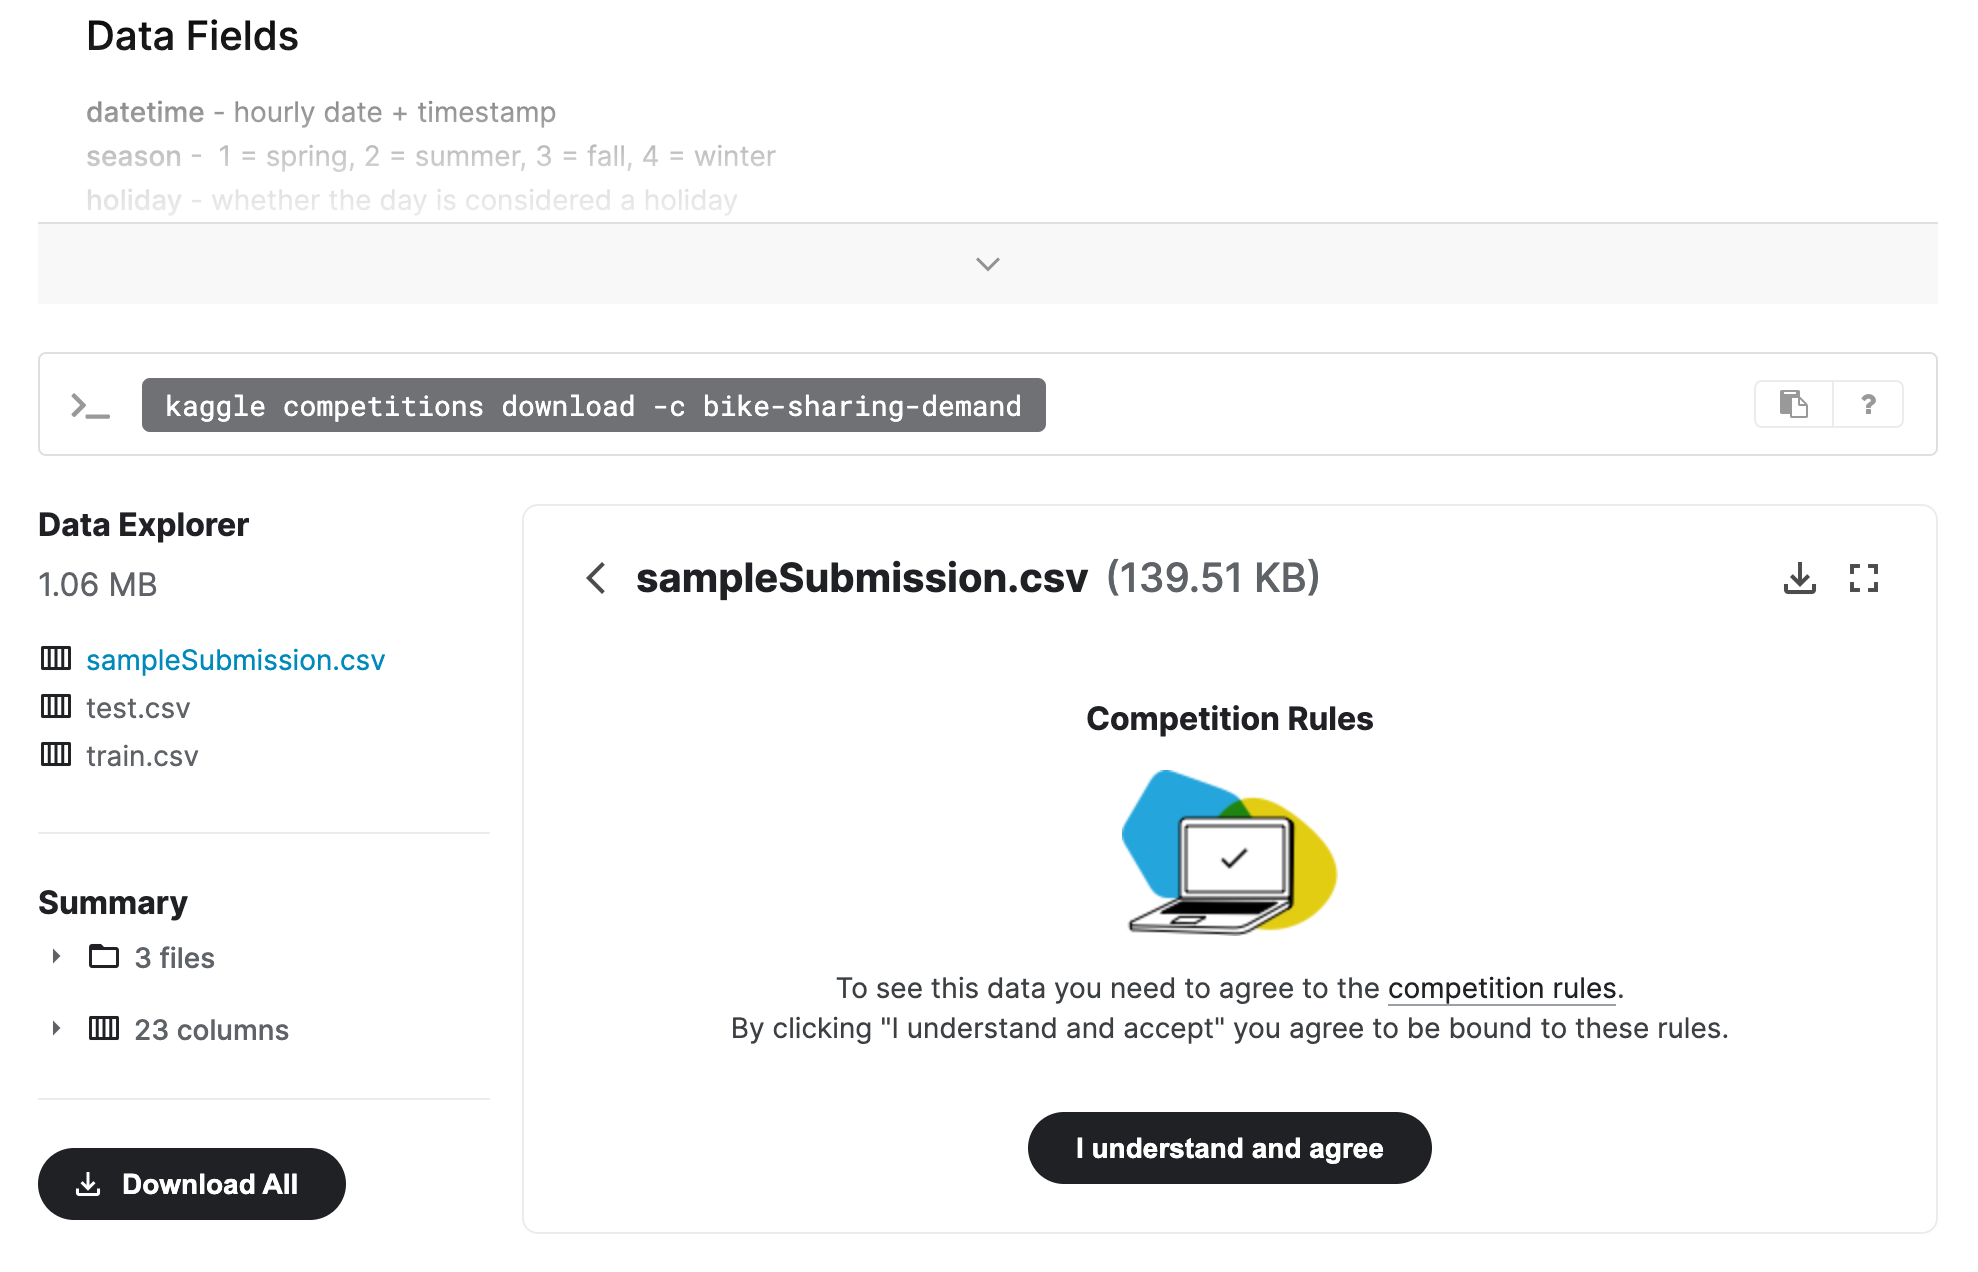

In [92]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [93]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [210]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
# Read the CSV file into a pandas DataFrame and parse the datetime column
train_data = pd.read_csv('train.csv', parse_dates=['datetime'])
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [186]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train_data.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [211]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test_data = pd.read_csv('test.csv', parse_dates=['datetime'])
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [212]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [220]:
# Define the label column
label_setting = 'count'

# Specify the columns to ignore
ignore_columns = ['casual', 'registered']

# Specify the time limit for training
time_limit = 600  # 10 minutes

# Fit the TabularPredictor
predictor = TabularPredictor(label=label_setting, 
                              eval_metric='root_mean_squared_error',
                              learner_kwargs={'ignored_columns':['casual','registered']},
                              path='ag_models',
                              verbosity=2)

# Fit the model with time limit and other parameters
predictor.fit(train_data=train_data,
              time_limit=time_limit,
              presets='best_quality',
              excluded_model_types=['KNN', 'GBM', 'NN'],
              hyperparameters={'RF': {'n_estimators': 300}})

Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: ag_models/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 60 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon: 540 seconds.
Starting ful

### Review AutoGluon's training run with ranking of models that did the best.

In [221]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model   score_val              eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  RandomForest_BAG_L1 -117.828056  root_mean_squared_error       0.361916   6.089417                0.361916           6.089417            1       True          1
1  WeightedEnsemble_L3 -117.828056  root_mean_squared_error       0.363130   6.129255                0.001214           0.039838            3       True          4
2  WeightedEnsemble_L2 -117.828056  root_mean_squared_error       0.363168   6.099271                0.001251           0.009855            2       True          2
3  RandomForest_BAG_L2 -124.163214  root_mean_squared_error       0.645759  15.020665                0.283843           8.931249            2       True          3
Number of models trained: 4
Types of models trained:
{'StackerEnsembleModel_RF', 'WeightedEnsembleModel'}
Bagging used

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'RandomForest_BAG_L1': -117.82805644902979,
  'WeightedEnsemble_L2': -117.82805644902979,
  'RandomForest_BAG_L2': -124.16321449395474,
  'WeightedEnsemble_L3': -117.82805644902979},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'RandomForest_BAG_L1': ['RandomForest_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'RandomForest_BAG_L2': ['RandomForest_BAG_L2'],
  'WeightedEnsemble_L3': ['WeightedEnsemble_L3']},
 'model_fit_times': {'RandomForest_BAG_L1': 6.08941650390625,
  'WeightedEnsemble_L2': 0.009854793548583984,
  'RandomForest_BAG_L2': 8.931248664855957,
  'WeightedEnsemble_L3': 0.039838314056396484},
 'model_pred_times': {'RandomForest_BAG_L1': 0.36191606521606445,
  'WeightedEnsemble_L2': 0.0012514591217041016,
  'Ra

### Create predictions from test dataset

In [222]:
# Generate predictions using the predictor object
predictions = predictor.predict(test_data)

In [223]:
print(predictions)

0        88.980949
1        86.504761
2        86.504761
3        92.723808
4        92.723808
           ...    
6488    306.990479
6489    306.990479
6490    281.457153
6491    213.085709
6492    282.619049
Name: count, Length: 6493, dtype: float32


#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [224]:
# Describe the `predictions` series to see if there are any negative values
description = predictions.describe()

# Check for negative values
negatives = (predictions < 0).any()

# Print the description and check result
print("Description of predictions series:")
print(description)

if negatives:
    print("The predictions contain negative values.")
else:
    print("The predictions doesn't contain negative values.")

Description of predictions series:
count    6493.000000
mean      219.093597
std       129.857895
min        16.857143
25%       119.476189
50%       189.028564
75%       295.342865
max       687.142883
Name: count, dtype: float64
The predictions doesn't contain negative values.


In [225]:
# Count the number of negative values in the predictions series
count_negatives = (predictions < 0).sum()

print("Count negative values:", count_negatives)

Count negative values: 0


In [226]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [227]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [228]:
submission_1=pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission_1['count']=predictions
submission_1.to_csv('submission_1.csv', index=False)                        

In [229]:
!kaggle competitions submit -c bike-sharing-demand -f submission_1.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 734kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [230]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_1.csv             2024-05-04 22:03:54  first raw submission               complete  1.41791      1.41791       
submission_3.csv             2024-05-04 21:19:35  new features with hyperparameters  complete  1.3209       1.3209        
submission_3.csv             2024-05-04 21:17:29  new features with hyperparameters  complete  1.41804      1.41804       
submission_2.csv             2024-05-04 20:48:53  new features                       complete  0.54701      0.54701       
tail: write error: Broken pipe


#### Initial score of `1.41791`

## Exploratory Data Analysis and Creating an additional feature


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

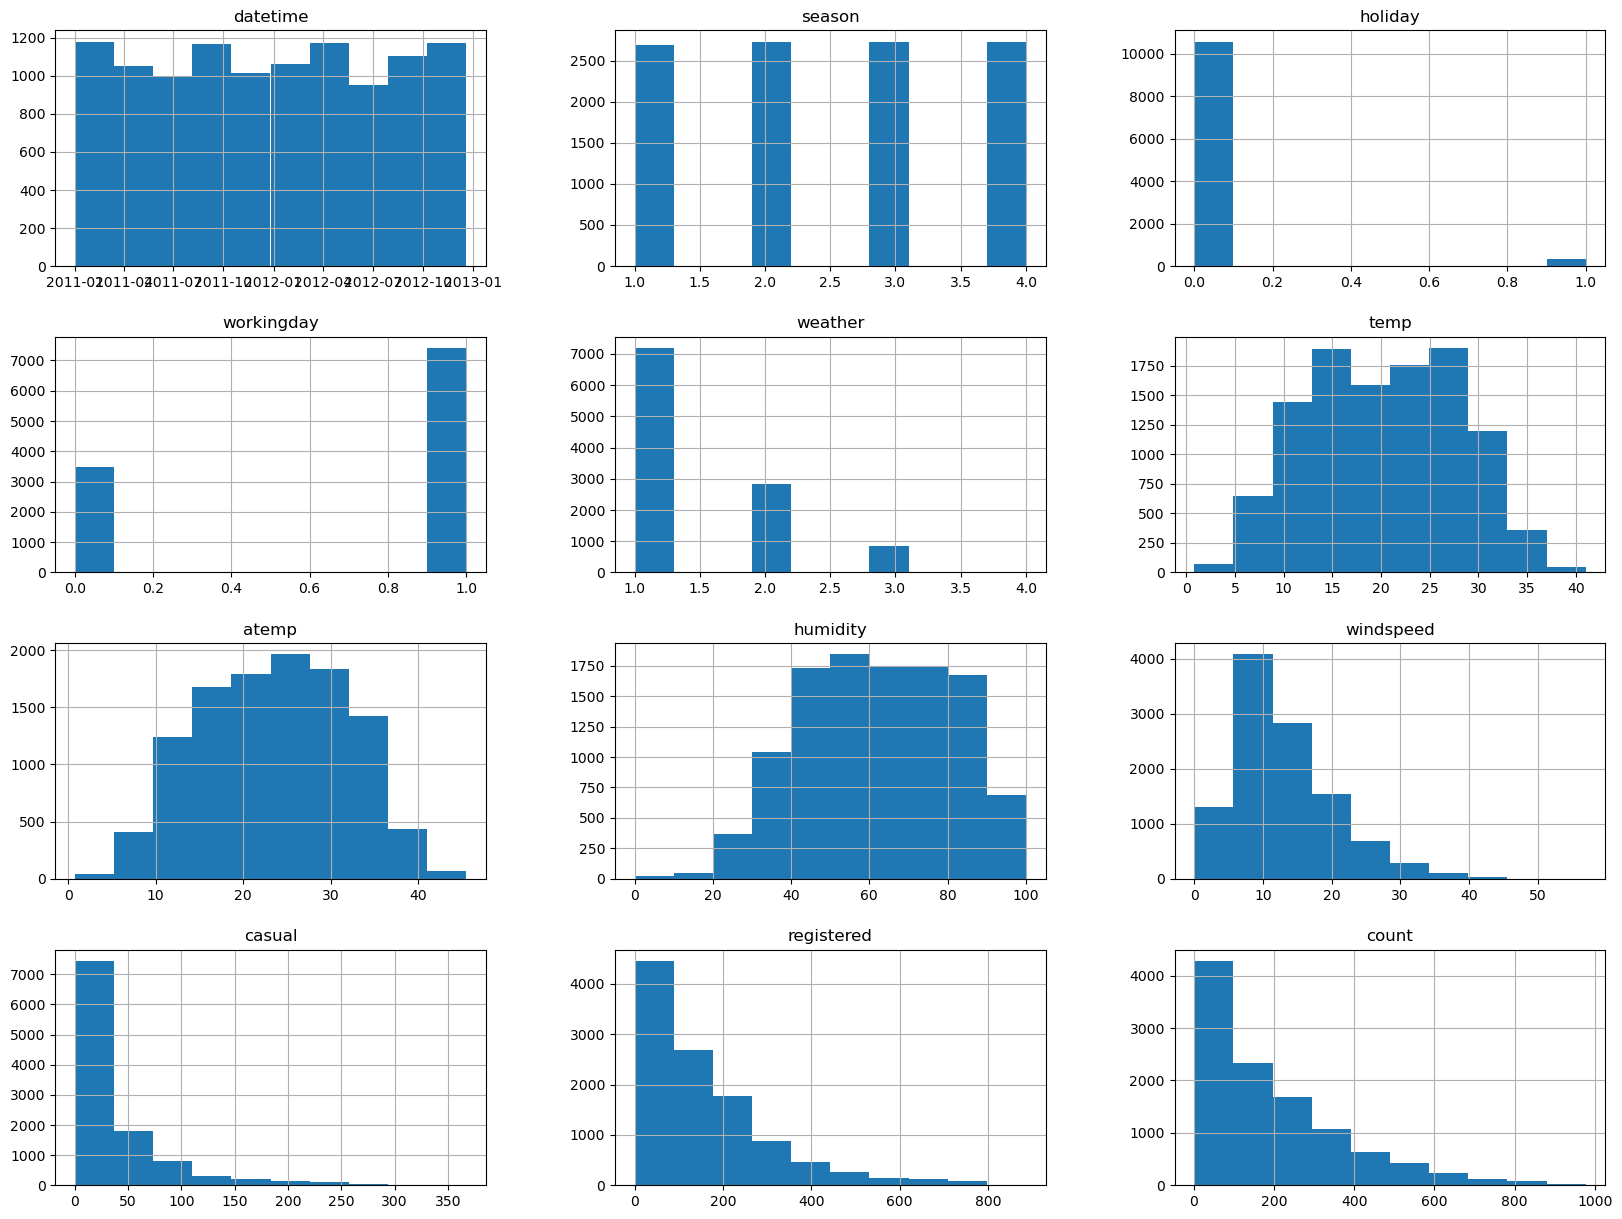

In [231]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train_data.hist(figsize=(20, 15))#figsize adjusted for better visualisation

In [232]:
# create a new feature
#Total number of using rental bikes to commute to work on a windy/non windy day
train_data['total_users'] = train_data['workingday'] + train_data['windspeed']
test_data['total_users'] = test_data['workingday'] + test_data['windspeed']

In [233]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,total_users
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,27.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,12.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,12.0014


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [234]:
train_data["season"] = train_data["season"].astype("category")
train_data["weather"] = train_data["weather"].astype("category")
test_data["season"] = test_data["season"].astype("category")
test_data["weather"] = test_data["weather"].astype("category")

In [235]:
# View are new feature
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,total_users
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,0.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,0.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,0.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0.0


In [236]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,total_users
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,27.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,12.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,12.0014


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>],
       [<Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'total_users'}>,
        <Axes: title={'center': 'hour'}>]], dtype=object)

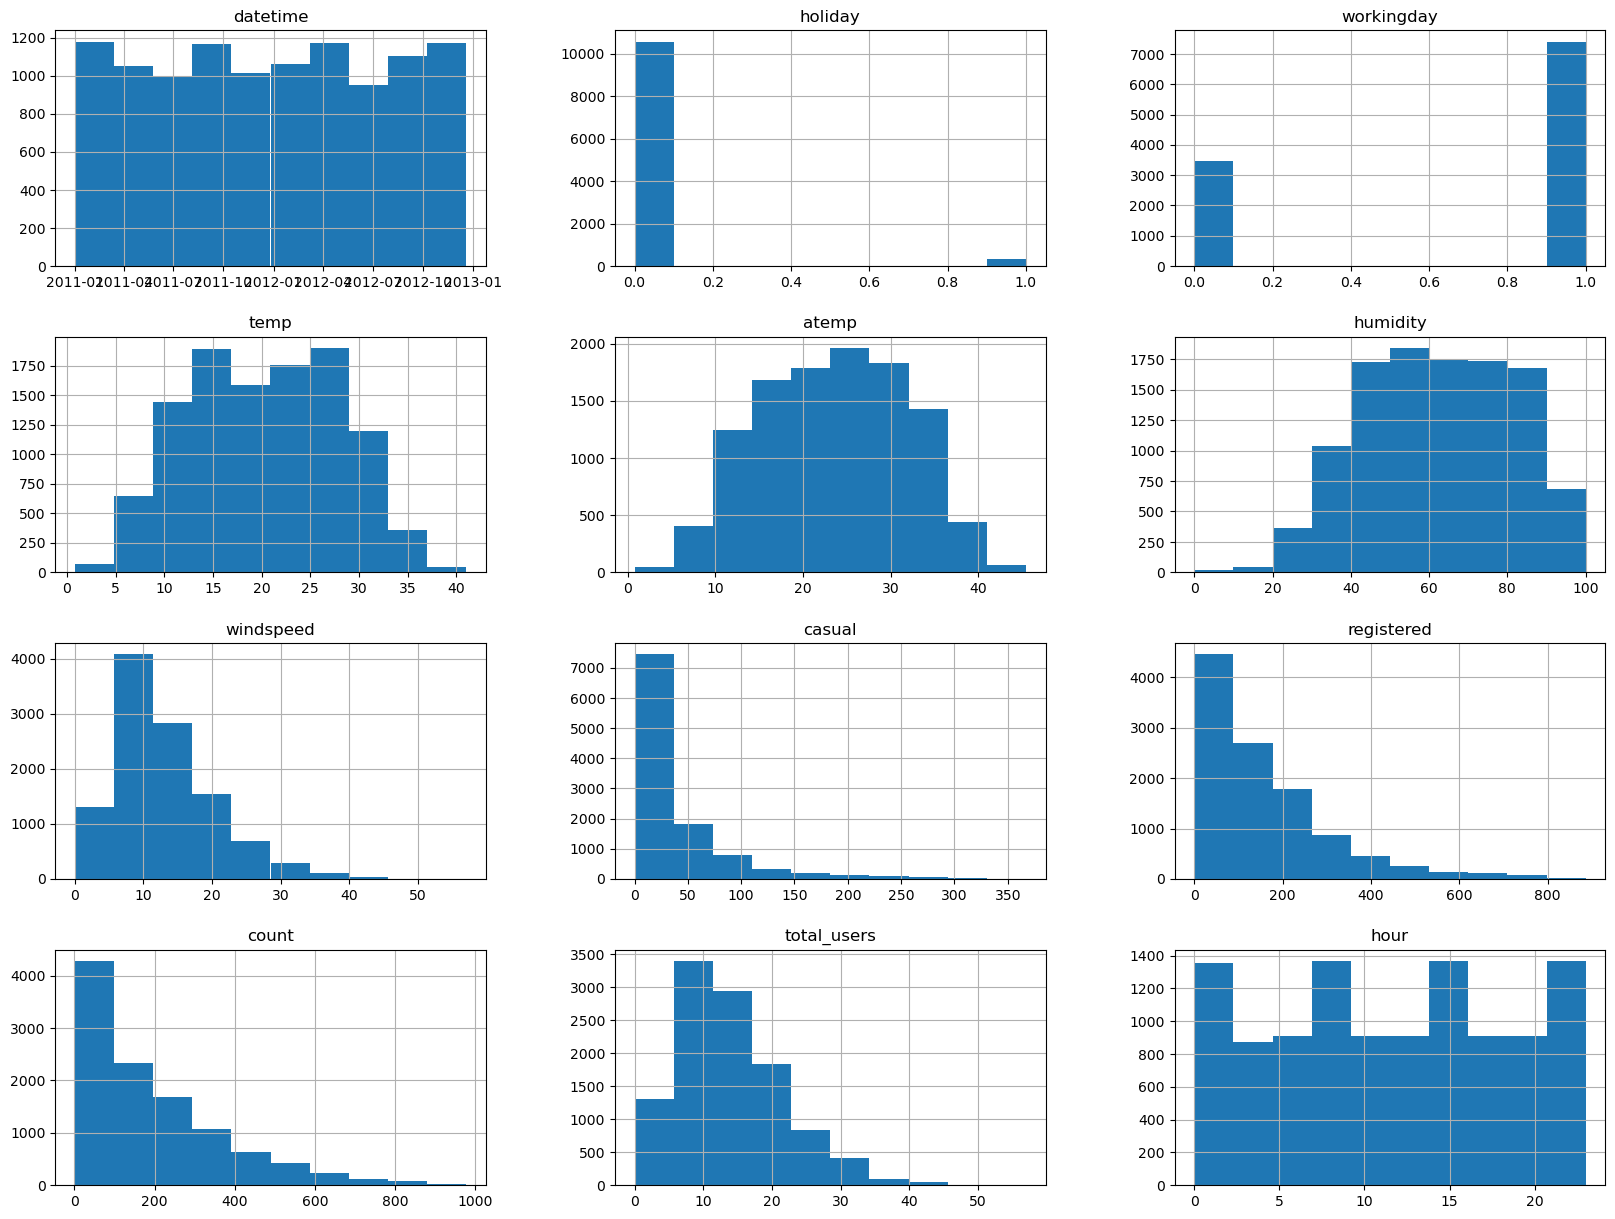

In [237]:
# View histogram of all features again now with the hour feature
# Extract hour
train_data['hour'] = train_data['datetime'].dt.hour
test_data['hour'] = test_data['datetime'].dt.hour
# View histogram of all features, including the 'hour' feature
train_data.hist(figsize=(20, 15))

In [238]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,total_users,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,27.0027,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1.0000,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1.0000,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,12.0014,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,12.0014,4


In [239]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,total_users,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0.0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,0.0,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,0.0,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,0.0,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0.0,4


## Reruning the model with the same settings as before, but more features

In [240]:
# Fit the TabularPredictor with the same settings, but with more features
predictor_new_features = TabularPredictor(label=label_setting,
                                          eval_metric='root_mean_squared_error',
                                          learner_kwargs={'ignored_columns':['casual','registered']},
                                          #path='new_ag_models',
                                          verbosity=2)

No path specified. Models will be saved in: "AutogluonModels/ag-20240504_220645"


In [241]:
# Fit the model with the updated training data
predictor_new_features.fit(train_data=train_data,
                            time_limit=time_limit,
                            presets='best_quality')

Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240504_220645/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 181 seconds for the sub-fit(s) during dynamic stacking.
Time left for full fit of AutoGluon:

In [242]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.439355  root_mean_squared_error      23.627251  386.416882                0.001304           0.084217            3       True         11
1          LightGBM_BAG_L2  -30.691049  root_mean_squared_error      20.810325  296.521412                0.383677          35.098094            2       True          9
2        LightGBMXT_BAG_L2  -31.197682  root_mean_squared_error      22.292667  306.125222                1.866019          44.701905            2       True          8
3   RandomForestMSE_BAG_L2  -32.011056  root_mean_squared_error      21.376252  306.532666                0.949604          45.109348            2       True         10
4      WeightedEnsemble_L2  -32.515365  root_mean_squared_error      20.339185  261.368453   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -34.832128218231134,
  'LightGBM_BAG_L1': -33.96666720058387,
  'RandomForestMSE_BAG_L1': -38.505771639858196,
  'CatBoost_BAG_L1': -36.393786889018706,
  'WeightedEnsemble_L2': -32.51536472015981,
  'LightGBMXT_BAG_L2': -31.197681807300143,
  'LightGBM_BAG_L2': -30.6910

In [243]:
submission_2=pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission_2['count']=prediction_new_features
submission_2.to_csv('submission_2.csv', index=False)

In [244]:
# Generate predictions using the predictor object
prediction_new_features = predictor_new_features.predict(test_data)

In [245]:
print(train_data.head())
print(test_data.head())

             datetime season  holiday  workingday weather  temp   atemp  \
0 2011-01-01 00:00:00      1        0           0       1  9.84  14.395   
1 2011-01-01 01:00:00      1        0           0       1  9.02  13.635   
2 2011-01-01 02:00:00      1        0           0       1  9.02  13.635   
3 2011-01-01 03:00:00      1        0           0       1  9.84  14.395   
4 2011-01-01 04:00:00      1        0           0       1  9.84  14.395   

   humidity  windspeed  casual  registered  count  total_users  hour  
0        81        0.0       3          13     16          0.0     0  
1        80        0.0       8          32     40          0.0     1  
2        80        0.0       5          27     32          0.0     2  
3        75        0.0       3          10     13          0.0     3  
4        75        0.0       0           1      1          0.0     4  
             datetime season  holiday  workingday weather   temp   atemp  \
0 2011-01-20 00:00:00      1        0          

In [246]:
prediction_new_features = [max(0,i) for i in prediction_new_features]

In [247]:
prediction_new_features[0:10]

[15.82194709777832,
 9.632197380065918,
 8.9218111038208,
 7.5194091796875,
 6.458874702453613,
 7.900975227355957,
 31.95417022705078,
 79.25601959228516,
 189.6488494873047,
 95.74197387695312]

In [248]:
submission_new_features = pd.read_csv('submission_2.csv')
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,22.134407
1,2011-01-20 01:00:00,4.017368
2,2011-01-20 02:00:00,2.469129
3,2011-01-20 03:00:00,6.218472
4,2011-01-20 04:00:00,6.623896


In [250]:
# Same submitting predictions
submission_new_features["count"] = prediction_new_features
submission_new_features.to_csv("submission_2.csv", index=False)

In [251]:
!kaggle competitions submit -c bike-sharing-demand -f submission_2.csv -m "new features"

100%|█████████████████████████████████████████| 243k/243k [00:00<00:00, 905kB/s]
Successfully submitted to Bike Sharing Demand

In [252]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_2.csv             2024-05-04 22:39:50  new features                       complete  0.62545      0.62545       
submission_1.csv             2024-05-04 22:03:54  first raw submission               complete  1.41791      1.41791       
submission_3.csv             2024-05-04 21:19:35  new features with hyperparameters  complete  1.3209       1.3209        
submission_3.csv             2024-05-04 21:17:29  new features with hyperparameters  complete  1.41804      1.41804       
tail: write error: Broken pipe


#### New Score of `0.62545`

## Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [253]:
#Defining variables for new hypo parameters
train_data = train_data
subsample_size = 1000  
train_data = train_data.sample(n=subsample_size, random_state=0)
label = 'count'
eval_metric='root_mean_squared_error'
print(train_data.head())

                datetime season  holiday  workingday weather   temp   atemp  \
6638 2012-03-13 21:00:00      1        0           1       1  23.78  27.275   
7975 2012-06-12 16:00:00      2        0           1       2  27.06  29.545   
5915 2012-02-02 16:00:00      1        0           1       1  18.86  22.725   
8050 2012-06-15 19:00:00      2        0           1       1  28.70  31.820   
5894 2012-02-01 19:00:00      1        0           1       1  22.14  25.760   

      humidity  windspeed  casual  registered  count  total_users  hour  
6638        56     7.0015      44         200    244       8.0015    21  
7975        89    19.0012      30         209    239      20.0012    16  
5915        55    19.0012      18         211    229      20.0012    16  
8050        42    11.0014      98         369    467      12.0014    19  
5894        52    19.0012      20         315    335      20.0012    19  


In [254]:
import pandas as pd
from autogluon.common import space
from autogluon.tabular import TabularPredictor

# Define hyperparameters and tuning settings
gbm_options = {
    'num_leaves': space.Int(lower=100, upper=500, default=100),
    'learning_rate': space.Real(lower=0.001, upper=0.15, default=0.1, log=True)
}
nn_options = {
    'learning_rate': space.Real(lower=0.001, upper=0.15, default=0.1, log=True),
    'num_epochs': 3,
    'activation': space.Categorical('relu', 'softrelu', 'tanh'),
    'dropout_prob': space.Real(0.0, 0.5, default=0.1)
}


hyperparameters = {
    'GBM': gbm_options,
    'NN_TORCH': nn_options,
}

hyperparameter_tune_kwargs = {
    'num_trials': 3,
    'searcher': 'random',
    'scheduler': 'local'
}

try:
    # Load the training data
    df_train = pd.read_csv('train.csv')

    # Train the TabularPredictor
    predictor_new_hpo = TabularPredictor(label='count', eval_metric="root_mean_squared_error").fit(
        df_train.drop(['casual', 'registered'], axis=1),
        time_limit=600,
        hyperparameters=hyperparameters,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        presets='best_quality'
    )

    print("Training completed successfully!")

except Exception as e:
    print("An error occurred during training:", e)

No path specified. Models will be saved in: "AutogluonModels/ag-20240504_224259"
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240504_224259/ds_sub_fit/sub_fit_ho.
Running the sub-fit in a ray process to avoid memory leakage.
Spend 87 seconds 

  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.56%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=3.71%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=3.77%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-131.0474	 = Validation score   (-root_mean_squared_error)
	40.08s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T2 ...
	-130.909	 = Validation score   (-root_mean_squared_error)
	47.98s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L1/T3 ...
	-131.0974	 = Validation score   (-root_mean_squared_error)
	99.38s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L1 ... Tuning model for up to 153.81s of the 324.9

  0%|          | 0/3 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.56%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=4.46%)
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=4.53%)
	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L2/T1 ...
	-129.8998	 = Validation score   (-root_mean_squared_error)
	31.91s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T2 ...
	-131.3952	 = Validation score   (-root_mean_squared_error)
	55.67s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBM_BAG_L2/T3 ...
	-130.722	 = Validation score   (-root_mean_squared_error)
	65.03s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L2 ... Tuning model for up to 146.03s of the 171.4

Training completed successfully!


In [257]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L3 -128.683156  root_mean_squared_error       0.001902  284.406847                0.001166           0.029616            3       True          8
1  WeightedEnsemble_L2 -129.821637  root_mean_squared_error       0.001724  187.473620                0.001247           0.035012            2       True          4
2   LightGBM_BAG_L2/T1 -129.899842  root_mean_squared_error       0.000615  219.348029                0.000139          31.909421            2       True          5
3   LightGBM_BAG_L2/T3 -130.721999  root_mean_squared_error       0.000598  252.467809                0.000121          65.029201            2       True          7
4   LightGBM_BAG_L1/T2 -130.908954  root_mean_squared_error       0.000146   47.981711                0.000146   

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM_BAG_L1/T1': -131.04737369754514,
  'LightGBM_BAG_L1/T2': -130.90895440586834,
  'LightGBM_BAG_L1/T3': -131.0974370632856,
  'WeightedEnsemble_L2': -129.82163684762165,
  'LightGBM_BAG_L2/T1': -129.89984193042633,
  'LightGBM_BAG_L2/T2': -131.3951569365666,
  'LightGBM_BAG_L2/T3': -130.72199930315824,
  'WeightedEnsemble_L3': -128.68315649661284},
 'model_best': 'WeightedEnsemble_L3',
 'model_paths': {'LightGBM_BAG_L1/T1': ['LightGBM_BAG_L1', 'T1'],
  'LightGBM_BAG_L1/T2': ['LightGBM_BAG_L1', 'T2'],
  'LightGBM_BAG_L1/T3': ['LightGBM_

In [258]:
# Generate predictions using the predictor object
prediction_hpo =predictor_new_hpo.predict(test_data)

In [259]:
prediction_hpo = [max(0,i) for i in prediction_hpo]

In [260]:
submission_3=pd.read_csv('sampleSubmission.csv',parse_dates=['datetime'])
submission_3['count']=prediction_hpo
submission_3.to_csv('submission_3.csv', index=False)

In [261]:
!kaggle competitions submit -c bike-sharing-demand -f submission_3.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 243k/243k [00:00<00:00, 852kB/s]
Successfully submitted to Bike Sharing Demand

In [262]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_3.csv             2024-05-04 23:03:43  new features with hyperparameters  complete  1.32974      1.32974       
submission_2.csv             2024-05-04 22:39:50  new features                       complete  0.62545      0.62545       
submission_1.csv             2024-05-04 22:03:54  first raw submission               complete  1.41791      1.41791       
submission_3.csv             2024-05-04 21:19:35  new features with hyperparameters  complete  1.3209       1.3209        
tail: write error: Broken pipe


#### New Score of `1.32974`

## Creating plots and table for report



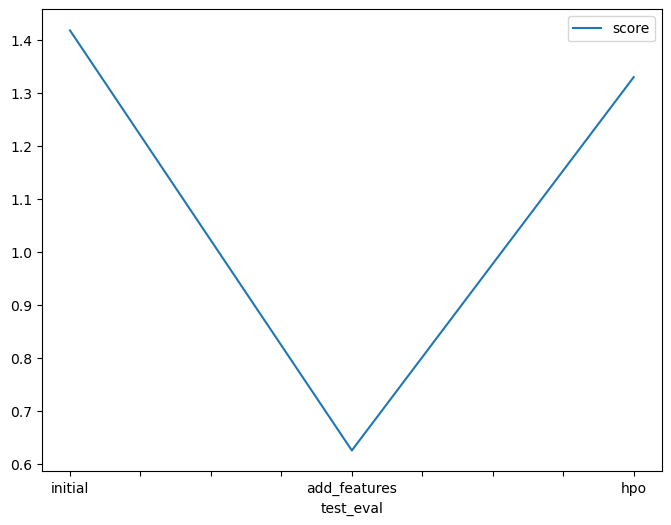

In [263]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.41791, 0.62545, 1.32974]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

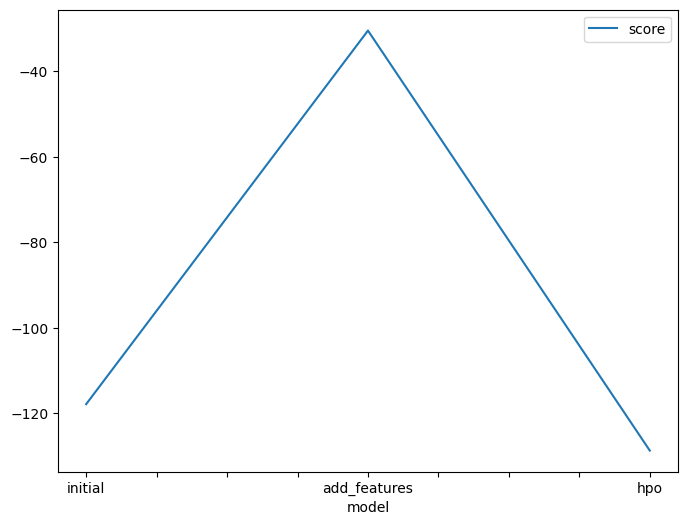

In [264]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [ -117.828056, -30.439355, -128.683156]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')




### Hyperparameter table

In [265]:
# The 3 hyperparameters we tuned with the kaggle score as the result

# Define hyperparameter options
rf_options = {
    'presets': 'best_quality',
    'excluded_model_types': ['KNN', 'GBM', 'NN'],
    'hyperparameters': {'RF': {'n_estimators': 300}}
}
gbm_options = {
    'presets': 'best_quality',
    'excluded_model_types': ['KNN', 'RF', 'NN'],
}
nn_options = {
    'presets': 'best_quality',
    'excluded_model_types': ['KNN', 'RF', 'GBM'],
}

# Create DataFrame
df = pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [rf_options, rf_options, rf_options],
    "hpo2": [rf_options, rf_options, rf_options],
    "hpo3": [gbm_options, gbm_options, nn_options],
    "score": [1.41791, 0.62545, 1.42059]
})

# Display DataFrame
print(df)


          model  \
0       initial   
1  add_features   
2           hpo   

                                                                                                                          hpo1  \
0  {'presets': 'best_quality', 'excluded_model_types': ['KNN', 'GBM', 'NN'], 'hyperparameters': {'RF': {'n_estimators': 300}}}   
1  {'presets': 'best_quality', 'excluded_model_types': ['KNN', 'GBM', 'NN'], 'hyperparameters': {'RF': {'n_estimators': 300}}}   
2  {'presets': 'best_quality', 'excluded_model_types': ['KNN', 'GBM', 'NN'], 'hyperparameters': {'RF': {'n_estimators': 300}}}   

                                                                                                                          hpo2  \
0  {'presets': 'best_quality', 'excluded_model_types': ['KNN', 'GBM', 'NN'], 'hyperparameters': {'RF': {'n_estimators': 300}}}   
1  {'presets': 'best_quality', 'excluded_model_types': ['KNN', 'GBM', 'NN'], 'hyperparameters': {'RF': {'n_estimators': 300}}}   
2  {'presets

In [ ]:
RandomForest_BAG_L1 -117.828056
WeightedEnsemble_L3  -30.439355
WeightedEnsemble_L3 -128.683156